# LNS Exploration | 12. Movielens_SBR

---

**[Introduce]**


* 전자상거래 플랫폼에서 자주 사용되는 Sassion Based Recommendation 기법을 활용해서, 영화추천 시스템을 만들어봅니다. 
* Session-Based Recommendation은 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천입니다.
* Session이란 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장됩니다. 


**[Data]**

* 추천시스템의 MNIST, Movielens 데이터
* 유저가 영화에 대해 평점을 매긴 데이터 중 MovieLens 1M Dataset 사용합니다.
    
These files contain 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.  

* 우리가 사용할 ratings.dat 는 'UserId', 'ItemId', 'Rating', 'Time' 컬럼으로 구성됩니다.

* 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용하겠습니다.

# 1. Data Preprocess


---

```python

SessionId : the total number of visits to your site — including both new and repeat visits  

UserId : Users means the number of unique visitors to your site
```




많은 서비스 기업에서는 Collaborative filtering(CF) 알고리즘과, Content based(CB) 추천 방식을 사용합니다. 그러나 이 방식은 유저가 본 상품들의 순서를 고려하지 않으므로 global 취향은 잘 고려할 수 있지만, local 취향 즉, '현재 가장 관심을 갖는' 상품이 무엇인지는 잘 알 수 가 없습니다. 또한 순서를 고려하지 않기 때문에, 유저들의 구매 패턴을 알아낼 수 없는 문제가 있습니다. 

이때, Session Based Recommendation Model은 유저들이 선택했던 아이템의 순서를 고려해 학습합니다.

---


그런데 우리가 사용할 ratings.dat 에는 SessionId가 아닌, UserId가 제공되므로, SBR을 위해서 UserId를 어떻게 SessionId로 재해석할 지 고민해야 합니다. 

In [1]:
#1) 데이터 확인
! ls -l ~/data

#2) 프로젝트 폴더 생성
! mkdir -p ~/aiffel/yoochoose

#3) 프로젝트 폴더로 데이터 폴더 링크 연결
! ln -s ~/data/* ~/aiffel/yoochoose/data

total 1893588
-rwxr-xr-x 1 root root       3973 May 17 06:12 dataset-README.txt
-rw-r--r-- 1 root root     171308 Jul 13 03:53 movies.dat
-rw-r--r-- 1 root root   24594131 Jul 13 03:54 ratings.dat
-rw-r--r-- 1 root root       5577 Jul 13 03:53 README
-rw-r--r-- 1 root root     134368 Jul 13 03:53 users.dat
-rwxr-xr-x 1 root root   55583744 May 17 06:12 yoochoose-buys.dat
-rwxr-xr-x 1 root root 1486798186 May 17 06:15 yoochoose-clicks.dat
-rwxr-xr-x 1 root root  371725851 May 17 06:13 yoochoose-test.dat
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/dataset-README.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/movies.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/ratings.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/README': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/users.dat': File exists
ln: failed to create symbolic lin

```python
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/README','r')
while True:
    line = f.readline()
    if not line: break
    print(line)
```

RATINGS FILE DESCRIPTION

================================================================================



All ratings are contained in the file "ratings.dat" and are in the

following format:



UserID::MovieID::Rating::Timestamp



- UserIDs range between 1 and 6040 

- MovieIDs range between 1 and 3952

- Ratings are made on a 5-star scale (whole-star ratings only)

- Timestamp is represented in seconds since the epoch as returned by time(2)

- Each user has at least 20 ratings



### 라이브러리 및 패키지 불러오기

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'


def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data


data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

```python
* 명확한 1회 세션의 SessionId를 포함하지 않기 때문에 UserId 가 SessionId 역할을 해야 합니다. 어떻게 Session 단위로 해석해야 할까요?

우선 groupby 메서드를 사용해서 각 유저가 시간당 몇회의 평가를 했는지 살펴보겠습니다. 

* Rating 정보를 어떻게 활용해야 할까요? 

rating은 유저가 영화에 대해 주는 별점으로 최저점1~ 최고점 5 의 값을 가집니다. 
직전에 봤던 영화에 1-2점의 평가를 한 경우엔 영화 추천에 의미가 없다고 판단하여 제거했습니다. 따라서 저희가 사용할 데이터는 3-5점의 평가를 받은 데이터입니다.

* Time 항목에는 UTC time 가 포함되어, 1970 년 1월 1일부터 경과된 초단위 시간이 기재됩니다. 

datetime.datetime.fromtimestamp() 를 사용하여 년월일 단위로 표현합니다.
```

In [5]:
#- UTC time을 datetime으로 변환

import datetime

data['Time'] = data['Time'].apply(lambda x : datetime.datetime.fromtimestamp(x))   

In [6]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


### SessionId 만들기

In [7]:
temp_data = data.groupby(['UserId', 'Time'])['ItemId'].count()

In [8]:
temp_data.head(15)

UserId  Time               
1       2000-12-31 22:00:19    1
        2000-12-31 22:00:55    3
        2000-12-31 22:01:43    1
        2000-12-31 22:02:52    1
        2000-12-31 22:04:35    1
        2000-12-31 22:11:59    2
        2000-12-31 22:12:40    3
        2000-12-31 22:22:48    1
        2000-12-31 22:23:18    1
        2000-12-31 22:26:10    1
        2000-12-31 22:26:30    1
        2000-12-31 22:26:59    1
        2000-12-31 22:28:33    1
        2000-12-31 22:29:12    1
        2000-12-31 22:29:13    2
Name: ItemId, dtype: int64

In [9]:
temp_data.shape

(471163,)

In [10]:
temp_data.describe()

count    471163.000000
mean          2.122851
std           1.546899
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: ItemId, dtype: float64

한 명의 사용자가 한 시각에 평균적으로 2회의 평가를 했으며, 75%의 사용자는 3회의 평가를 했기 때문에, 4회 이상의 평가는 이상치라고 판단하여 제거합니다. 

In [11]:
data = pd.merge(data, temp_data, how='inner', on=['UserId','Time'])

In [12]:
data = data.rename(columns={'ItemId_x':'ItemId'})
data = data.rename(columns={'ItemId_y':'ItemId_Count'})

In [13]:
data = data[data['ItemId_Count']< 4]

In [14]:
data.sort_values(['UserId','Time'])

,UserId,ItemId,Rating,Time,ItemId_Count
0,1,3186,4,2000-12-31 22:00:19,1
1,1,1270,5,2000-12-31 22:00:55,3
2,1,1721,4,2000-12-31 22:00:55,3
3,1,1022,5,2000-12-31 22:00:55,3
4,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,1
1000205,6040,1921,4,2001-08-10 14:41:04,2
1000206,6040,1784,3,2001-08-10 14:41:04,2
1000207,6040,161,3,2001-08-10 14:41:26,1


In [15]:
cond1 = data['Time'] - data['Time'].shift(1) > datetime.timedelta(minutes = 30) 
cond2 = data['UserId'] != data['UserId'].shift(1) 
data['SessionId'] = (cond1|cond2).cumsum() 
data

,UserId,ItemId,Rating,Time,ItemId_Count,SessionId
0,1,3186,4,2000-12-31 22:00:19,1,1
1,1,1270,5,2000-12-31 22:00:55,3,1
2,1,1721,4,2000-12-31 22:00:55,3,1
3,1,1022,5,2000-12-31 22:00:55,3,1
4,1,2340,3,2000-12-31 22:01:43,1,1
...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,1,25026
1000205,6040,1921,4,2001-08-10 14:41:04,2,25026
1000206,6040,1784,3,2001-08-10 14:41:04,2,25026
1000207,6040,161,3,2001-08-10 14:41:26,1,25026


총 2만 5000 여개의 SessionId가 형성되었습니다.

### 평점
영화 추천에 유의미하다고 판단한 평점 3 이상만 남깁니다.

movielen.org 홈페이지에 들어가보니 별점만 체크하는 시스템이라 짧은 시간 안에 1~3개의 평점을 매기는 것을 이상치가 아닐 수 있지만,
3개를 초과하는 데이터는 이상치로 판단했습니다.

In [16]:
data = data[data['Rating']>= 3]
data

,UserId,ItemId,Rating,Time,ItemId_Count,SessionId
0,1,3186,4,2000-12-31 22:00:19,1,1
1,1,1270,5,2000-12-31 22:00:55,3,1
2,1,1721,4,2000-12-31 22:00:55,3,1
3,1,1022,5,2000-12-31 22:00:55,3,1
4,1,2340,3,2000-12-31 22:01:43,1,1
...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,1,25026
1000205,6040,1921,4,2001-08-10 14:41:04,2,25026
1000206,6040,1784,3,2001-08-10 14:41:04,2,25026
1000207,6040,161,3,2001-08-10 14:41:26,1,25026


### Session Length

In [17]:
#- Session Length
session_length = data.groupby(data['SessionId']).size()
session_length

SessionId
1        40
2         8
3        95
4        46
5         7
         ..
25023     7
25024    13
25025     1
25026    21
25027     1
Length: 23924, dtype: int64

In [18]:
session_length.median(), session_length.mean()

(5.0, 22.28548737669286)

In [19]:
session_length.min(), session_length.max()

(1, 545)

In [20]:
session_length.quantile(0.95)

101.0

session_length가 100 이상인 데이터는 지우도록 하겠습니다. 

In [21]:
long_session = session_length[session_length==545].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,ItemId_Count,SessionId
610740,3705,3015,3,2000-08-14 19:14:15,3,15879
610741,3705,260,5,2000-08-14 19:14:15,3,15879
610742,3705,125,4,2000-08-14 19:14:15,3,15879
610743,3705,1617,4,2000-08-14 19:14:38,1,15879
610745,3705,1193,4,2000-08-14 19:15:04,3,15879
...,...,...,...,...,...,...
611522,3705,3067,4,2000-08-14 21:28:02,2,15879
611523,3705,363,4,2000-08-14 21:28:02,2,15879
611524,3705,2245,3,2000-08-14 21:28:26,1,15879
611525,3705,2919,4,2000-08-14 21:28:46,1,15879


In [22]:
length_count = session_length.groupby(session_length).size()
length_count

1      6781
2      2475
3      1348
4       909
5       703
       ... 
424       1
432       2
495       1
521       1
545       1
Length: 315, dtype: int64

In [23]:
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.283439
2      0.386892
3      0.443237
4      0.481232
5      0.510617
         ...   
325    0.998830
327    0.998871
332    0.998913
334    0.998955
336    0.998997
Length: 294, dtype: float64

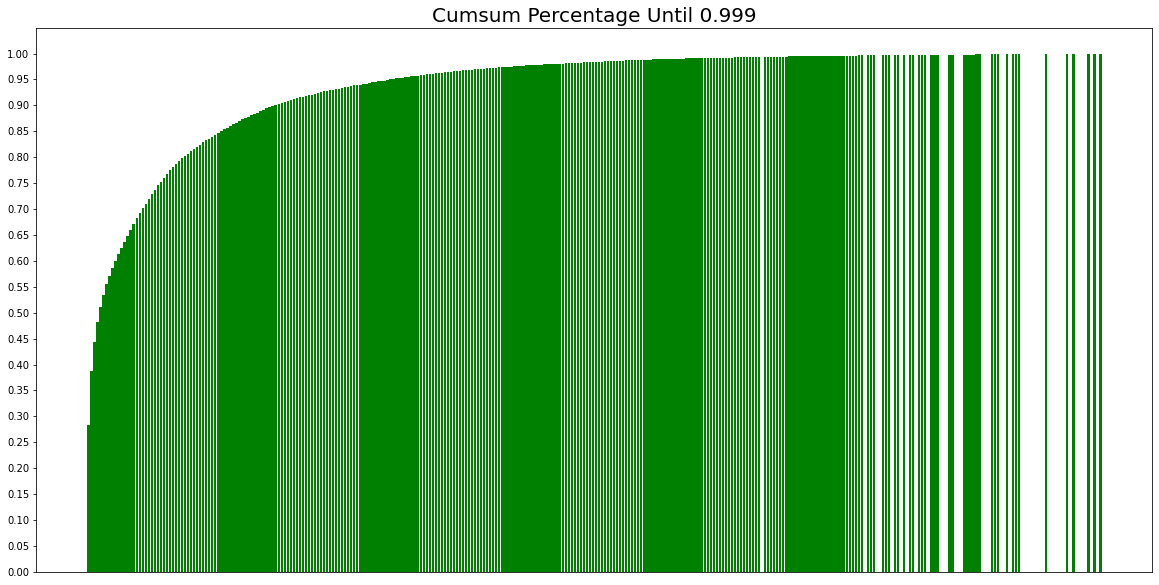

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure(figsize=(20,10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)

ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.show()

In [25]:
session_length = session_length[session_length <= 100]

In [26]:
session_length.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,    10,
               11,
            ...
            25018, 25019, 25020, 25021, 25022, 25023, 25024, 25025, 25026,
            25027],
           dtype='int64', name='SessionId', length=22701)

In [27]:
data = data[data['SessionId'].isin(session_length.index)]

In [28]:
data

,UserId,ItemId,Rating,Time,ItemId_Count,SessionId
0,1,3186,4,2000-12-31 22:00:19,1,1
1,1,1270,5,2000-12-31 22:00:55,3,1
2,1,1721,4,2000-12-31 22:00:55,3,1
3,1,1022,5,2000-12-31 22:00:55,3,1
4,1,2340,3,2000-12-31 22:01:43,1,1
...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,1,25026
1000205,6040,1921,4,2001-08-10 14:41:04,2,25026
1000206,6040,1784,3,2001-08-10 14:41:04,2,25026
1000207,6040,161,3,2001-08-10 14:41:26,1,25026


### Session Time
* 유저들의 취향과 선호도는 변화하기 마련이다. 때문에 추천시스템 구축 시 최근 트렌드를 학습하는 것이 중요하다. 

In [29]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


3년치 데이터가 있습니다. 이 중 2년치의 데이터를 사용해보겠습니다!

In [30]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [31]:
month_ago = latest - dt.timedelta(1020)
data[data['Time'] > month_ago]

,UserId,ItemId,Rating,Time,ItemId_Count,SessionId
0,1,3186,4,2000-12-31 22:00:19,1,1
1,1,1270,5,2000-12-31 22:00:55,3,1
2,1,1721,4,2000-12-31 22:00:55,3,1
3,1,1022,5,2000-12-31 22:00:55,3,1
4,1,2340,3,2000-12-31 22:01:43,1,1
...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,1,25026
1000205,6040,1921,4,2001-08-10 14:41:04,2,25026
1000206,6040,1784,3,2001-08-10 14:41:04,2,25026
1000207,6040,161,3,2001-08-10 14:41:26,1,25026


### Data Cleansing
* 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로, 길이가 1인 세션은 제거해주겠습니다. 

* 너무 적게 클릭된 아이템은 제거해주겠습니다. 

In [32]:
#- short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음 
#- 이를 위해 반복문을 통해 지속적으로 제거함 

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame :
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
            
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index #- shortest 보다 빈도수가 큰 sessionId의 rows 불러오기
    data = data[data['SessionId'].isin(session_use)] #- session use 에 해당되는 row만 data 데이터프레임에 저장
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [33]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,ItemId_Count,SessionId
0,1,3186,4,2000-12-31 22:00:19,1,1
1,1,1270,5,2000-12-31 22:00:55,3,1
2,1,1721,4,2000-12-31 22:00:55,3,1
3,1,1022,5,2000-12-31 22:00:55,3,1
4,1,2340,3,2000-12-31 22:01:43,1,1
...,...,...,...,...,...,...
1000203,6040,232,5,2001-08-10 14:39:58,1,25026
1000204,6040,2917,4,2001-08-10 14:40:29,1,25026
1000205,6040,1921,4,2001-08-10 14:41:04,2,25026
1000206,6040,1784,3,2001-08-10 14:41:04,2,25026


In [34]:
data = data[['SessionId','ItemId','Time']]

### Train/Valid/Test Split

In [35]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max() #- 마지막날 
    
    session_last_time = data.groupby('SessionId')['Time'].max() #- 세션 아이디별로 가장 마지막 접속 시간
    #- 세션의 마지막 접속시간이 Timestamp('2014-09-29 02:59:59.430000+0000', tz='UTC')보다 이른 sessionId
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [36]:
final_time = data['Time'].max()
print(final_time)

2003-02-28 17:49:50


In [37]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [38]:
print(tr)
print(test)
print(val)

         SessionId  ItemId                Time
0                1    3186 2000-12-31 22:00:19
1                1    1270 2000-12-31 22:00:55
2                1    1721 2000-12-31 22:00:55
3                1    1022 2000-12-31 22:00:55
4                1    2340 2000-12-31 22:01:43
...            ...     ...                 ...
1000203      25026     232 2001-08-10 14:39:58
1000204      25026    2917 2001-08-10 14:40:29
1000205      25026    1921 2001-08-10 14:41:04
1000206      25026    1784 2001-08-10 14:41:04
1000207      25026     161 2001-08-10 14:41:26

[327376 rows x 3 columns]
        SessionId  ItemId                Time
8789          129    2997 2003-01-07 18:02:48
8791          129    2369 2003-01-07 18:04:24
8792          129    3408 2003-01-07 18:04:52
8793          129    2712 2003-01-07 18:04:52
8794          129    2716 2003-01-07 18:05:31
...           ...     ...                 ...
984904      24734    3893 2003-02-27 18:12:49
984905      24734    3948 2003-02-27 18:1

In [39]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [40]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 327376
	 Sessions: 15493
	 Items: 3040
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-10-31 16:33:08

* valid Set Stats Info
	 Events: 1674
	 Sessions: 182
	 Items: 1001
	 First Time : 2002-11-01 02:56:19
	 Last Time : 2002-12-30 16:54:04

* test Set Stats Info
	 Events: 1728
	 Sessions: 196
	 Items: 1006
	 First Time : 2002-12-30 19:06:03
	 Last Time : 2003-02-28 17:49:50



In [41]:
#- train set 에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱함

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x,-1)) #- id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

    


### data pipeline 구축

In [42]:
#- data pipeline 구축 

save_path = data_path / 'processed_node'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. Modeling

### Session-Parallel Mini-Batch 
* Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

In [43]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())
    
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [44]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,ItemId,Time,item_idx
0,1,3186,2000-12-31 22:00:19,0
1,1,1270,2000-12-31 22:00:55,1
2,1,1721,2000-12-31 22:00:55,2
3,1,1022,2000-12-31 22:00:55,3
4,1,2340,2000-12-31 22:01:43,4
5,1,1836,2000-12-31 22:02:52,5
6,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
8,1,1207,2000-12-31 22:11:59,8
9,1,1193,2000-12-31 22:12:40,9


In [45]:
#- 각 세션이 시작된 인덱스

tr_dataset.click_offsets

array([     0,     40,     48, ..., 327342, 327355, 327376], dtype=int32)

In [46]:
#- 각 세션 인덱싱 

tr_dataset.session_idx

array([    0,     1,     2, ..., 15490, 15491, 15492])

### SessionDataLoader

In [47]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [48]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,ItemId,Time,item_idx
0,1,3186,2000-12-31 22:00:19,0
1,1,1270,2000-12-31 22:00:55,1
2,1,1721,2000-12-31 22:00:55,2
3,1,1022,2000-12-31 22:00:55,3
4,1,2340,2000-12-31 22:01:43,4
5,1,1836,2000-12-31 22:02:52,5
6,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
8,1,1207,2000-12-31 22:11:59,8
9,1,1193,2000-12-31 22:12:40,9


In [49]:
iter_ex = iter(tr_data_loader)

In [50]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 40 48 59]
Label Item Idx are :       [ 1 41 49 57]
Previous Masked Input Idx are []


### Evaluation Metric
* recall@k : recall 개념을 확장한 지표
* MRR : 정답 아이템이 나온 순번의 역수 값

In [51]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [53]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [54]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20)

In [55]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3040)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      463800    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3040)                155040    
Total params: 618,840
Trainable params: 618,840
Non-trainable params: 0
_________________________________________________________________


In [56]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

# 3. Train

In [57]:
train_model(model, args)

Train:   0%|          | 0/4873 [00:00<?, ?it/s, accuracy=0, train_loss=6.73]     

	 - Recall@20 epoch 1: 0.076563
	 - MRR@20    epoch 1: 0.013657



Train:   0%|          | 0/4873 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.29]

	 - Recall@20 epoch 2: 0.123438
	 - MRR@20    epoch 2: 0.031058



Train:   0%|          | 0/4873 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.12]

	 - Recall@20 epoch 3: 0.131250
	 - MRR@20    epoch 3: 0.036219



Train:   0%|          | 0/4873 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.97]

	 - Recall@20 epoch 4: 0.131250
	 - MRR@20    epoch 4: 0.040372



Train:   0%|          | 0/4873 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.71]

	 - Recall@20 epoch 5: 0.139063
	 - MRR@20    epoch 5: 0.039843



Train:   0%|          | 0/4873 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.66]

	 - Recall@20 epoch 6: 0.139063
	 - MRR@20    epoch 6: 0.040497



Evaluation:  43%|████▎     | 10/23 [00:04<00:05,  2.46it/s]

	 - Recall@20 epoch 7: 0.140625
	 - MRR@20    epoch 7: 0.040708



# 4. Test
미리 구성한 테스트셋을 바탕으로 Recall, Mrr 확인해봅니다.

```pythion

<첫번째 시도>

tr, test = split_by_date(data, n_days=200)
tr, val = split_by_date(tr, n_days=200)

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20)

- Recall@20 epoch 7: 0.121299
- MRR@20    epoch 7: 0.029934



<두번째 시도>

tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

- Recall@20 epoch 20: 0.159091
- MRR@20    epoch 20: 0.045211


<세번째 시도>

    * train Set Stats Info
         Events: 327376
         Sessions: 15493
         Items: 3040
         First Time : 2000-04-25 23:05:32
         Last Time : 2002-10-31 16:33:08

    * valid Set Stats Info
         Events: 1674
         Sessions: 182
         Items: 1001
         First Time : 2002-11-01 02:56:19
         Last Time : 2002-12-30 16:54:04

    * test Set Stats Info
         Events: 1728
         Sessions: 196
         Items: 1006
         First Time : 2002-12-30 19:06:03
         Last Time : 2003-02-28 17:49:50

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20)

- Recall@20 epoch 7: 0.140625
- MRR@20    epoch 7: 0.040708

```